In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [2]:
def DiffE_theta(theta, om, J12, J1, J2):
    K = J12/J1
    return [-J12 * np.sin(theta[0]-theta[1]) - J1 * np.sin(theta[0]-om[0]),
            J12 * np.sin(theta[0]-theta[1]) - J2 * np.sin(theta[1]-om[1])]

def Jac_theta(theta, om, J12, J1, J2):
    return [[-J12 * np.cos(theta[0]-theta[1]) - J1 * np.cos(theta[0]-om[0]), J12 * np.cos(theta[0]-theta[1])],
            [J12 * np.cos(theta[0]-theta[1]), -J12 * np.cos(theta[0]-theta[1]) - J2 * np.cos(theta[1]-om[1])]]


def check_constraint_comp(theta, om, theta0):
    '''Return True if theta1 is in N(om1, theta0) and theta2 is in N(om2, theta0).'''
    return abs(theta[0]-om[0]) <= theta0 and abs(theta[1]-om[1]) <= theta0

def check_constraint_dec(theta, om, theta0):
    '''Return True if theta1 is in N(om1, theta0) and theta2 is not in N(om2, theta0).'''
    return abs(theta[0]-om[0]) <= theta0 and abs(theta[1]-om[1]) > theta0

def is_stable(theta, om, J12, J1, J2):
    J = Jac_theta(theta, om, J12, J1, J2)
    # Compute the eigenvalues of the Jacobian matrix
    # eigenvalues, _ = np.linalg.eig(jac_matrix)
    # Check stability
    #return (J[0][0]>0) and (np.linalg.det(J)>0)
    # if all(eigenvalues.real < 0):
    #     return True
    # else:
    #     return False
    return np.all(np.real(np.linalg.eigvals(J))<0)

In [3]:
# COMPROMISE
print('COMPROMISE')
J12 = 10
Jmax = 6
J1 = Jmax
J2 = Jmax
T = 100
om1 = np.radians(40)
om2 = np.radians(0)
theta0 = np.radians(20)

theta_i = [np.radians(20), np.radians(20)]
om = [om1, om2]

theta_sol_comp = fsolve(DiffE_theta, theta_i, args=(om, J12, J1, J2))

print('theta_sol_comp =', np.degrees(np.around(theta_sol_comp, 5)))

#check that theta_sol_comp is a solution of the equation
print('DiffE_theta(theta_sol_comp) =', np.around(DiffE_theta(theta_sol_comp, om, J12, J1, J2),5))

#check that theta_sol_comp satisfies the constraint
print('check_constraint(theta_sol_comp) =', check_constraint_comp(theta_sol_comp, om, theta0))

# DECISION
print('\nDECISION')
J1 = Jmax
J2 = 0

theta_sol_dec = fsolve(DiffE_theta, theta_i, args=(om, J12, J1, J2))

print('theta_sol_dec =', np.degrees(np.around(theta_sol_dec, 5)))

#check that theta_sol_dec is a solution of the equation
print('DiffE_theta(theta_sol_dec) =', np.around(DiffE_theta(theta_sol_dec, om, J12, J1, J2),5))

#check that theta_sol_dec satisfies the constraint
print('check_constraint(theta_sol_dec) =', check_constraint_dec(theta_sol_dec, om, theta0))

COMPROMISE
theta_sol_comp = [24.58791082 15.41256469]
DiffE_theta(theta_sol_comp) = [0. 0.]
check_constraint(theta_sol_comp) = True

DECISION
theta_sol_dec = [39.99990255 39.99990255]
DiffE_theta(theta_sol_dec) = [-0.  0.]
check_constraint(theta_sol_dec) = True


In [4]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'om', 'theta0', 'theta'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'om', 'theta0', 'theta'])

# solve the equation for different values of J12, Jmax and T

theta0 = np.radians(20)

# J12 = 10
Jmax = 10
om2 = 0

for om1 in np.arange(0, np.pi, np.pi/60):
    for J12 in np.linspace(1, 300, 150):
        theta_i = [om1, om2]
        om = [om1, om2]
        theta_comp = fsolve(DiffE_theta, theta_i, args=(om, J12, Jmax, Jmax))
        theta_dec = fsolve(DiffE_theta, theta_i, args=(om, J12, Jmax, 0))

        # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'om': om, 'theta0': theta0, 'theta': theta_comp}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'om': om, 'theta0': theta0, 'theta': theta_dec}, ignore_index=True)


In [5]:
# add a row with the check of the constraint
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp(row['theta'], row['om'], row['theta0']), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec(row['theta'], row['om'], row['theta0']), axis=1)

df_comp['is_stable'] = df_comp.apply(lambda row: is_stable(row['theta'], row['om'], row['J12'], row['J1'], row['J2']), axis=1)
df_dec['is_stable'] = df_dec.apply(lambda row: is_stable(row['theta'], row['om'], row['J12'], row['J1'], row['J2']), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om'][0] - row['om'][1], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om'][0] - row['om'][1], axis=1)

In [6]:
comp = df_comp[(df_comp['is_sol'] == True) & (df_comp['is_stable'] == True)]
dec = df_dec[(df_dec['is_sol'] == True) & (df_dec['is_stable'] == True)]

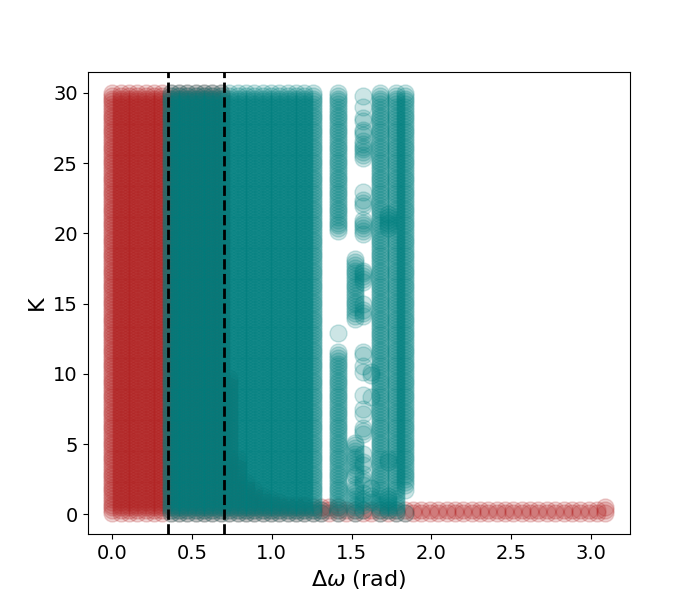

In [7]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_ylabel('K', fontsize=16)
# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 10)
# ax.set_xlim(0, np.pi)
# ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.2, c='firebrick')
# ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.2, c='teal')
ax.scatter(comp['omega_diff'], comp['J12']/comp['J1'], s=150, alpha=0.2, c='firebrick')
ax.scatter(dec['omega_diff'], dec['J12']/dec['J1'], s=150, alpha=0.2, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()